##### Copyright 2019 The TensorFlow Authors. [Licensed under the Apache License, Version 2.0](#scrollTo=y_UVSRtBBsJk).

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
// Licensed under the Apache License, Version 2.0 (the "License");
// you may not use this file except in compliance with the License.
// You may obtain a copy of the License at
//
// https://www.apache.org/licenses/LICENSE-2.0
//
// Unless required by applicable law or agreed to in writing, software
// distributed under the License is distributed on an "AS IS" BASIS,
// WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
// See the License for the specific language governing permissions and
// limitations under the License.

# Image Classification using Swift for TensorFlow

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/13lBsht3Wa4GjKKkA47JCrd54XikhNX2E"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="Link to be updated"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />GitHub link to be updated accordingly</a>
  </td>
</table>

In this Colab you will classify images of flowers. We'll build an image classifier using `Layer` and load data by creating training and validation tensors of images as well as their corresponding labels.

# Importing packages

Let's start by importing required packages:

*   glob — to read files and directory structure.
*   numpy — for some matrix math outside of TensorFlow.
*   matplotlib.pyplot — to plot the graph and display images in our training and validation data.
*  PIL — to view images.

In [0]:
import TensorFlow
import Foundation
import Python

%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let np = Python.import("numpy")  // Make numpy available using np.
let subprocess = Python.import("subprocess")
let plt = Python.import("matplotlib.pyplot")
let os = Python.import("os")
let glob = Python.import("glob")
let pil = Python.import("PIL")
let pilImageOps = Python.import("PIL.ImageOps")
let random = Python.import("random")
let sk = Python.import("skimage")

In order to build our image classifier, we can begin by downloading the flowers dataset.  

In [0]:
public extension String {
    @discardableResult
    func shell(_ args: String...) -> String {
        let (task, pipe) = (Process(), Pipe())
        task.executableURL = URL(fileURLWithPath: self)
        (task.arguments, task.standardOutput) = (args, pipe)
        do    { try task.run() }
        catch { print("Unexpected error: \(error).") }

        let data = pipe.fileHandleForReading.readDataToEndOfFile()
        return String(data: data, encoding: String.Encoding.utf8) ?? ""
    }
}

In [4]:
print("/bin/ls".shell("-lh"))

total 4.0K
drwxr-xr-x 1 root root 4.0K Aug 22 16:14 sample_data



In order to build our image classifier, we can begin by downloading the flowers dataset. We first need to download the archive version of the dataset and after the download, we unzip it.

In [5]:
let command = "wget -nv -O- https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz | tar xzf - -C ."
subprocess.call(command, shell: true)

2019-08-25 20:38:28 URL:https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz [228813984/228813984] -> "-" [1]


0


The  dataset we downloaded contains images of 5 types of flowers:

1. Rose
2. Daisy
3. Dandelion
4. Sunflowers
5. Tulips

So, let's create the labels for these 5 classes: 

In [0]:
let classNames = ["roses", "daisy", "dandelion", "sunflowers", "tulips"]

Also, the dataset we have downloaded has following directory structure:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>diasy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

In [7]:
let filelist = try FileManager.default.contentsOfDirectory(atPath: "./flower_photos/daisy")
for filename in filelist[0..<10] {
    print(filename)
}

3764116502_f394428ee0_n.jpg
5434901893_4550be3f84_m.jpg
8759177308_951790e00d_m.jpg
11023272144_fce94401f2_m.jpg
4432271543_01c56ca3a9.jpg
5608389827_a42a46f760.jpg
3711723108_65247a3170.jpg
3386988684_bc5a66005e.jpg
2812442552_3eed5fb9f2_m.jpg
5058708968_8bdcd29e63_n.jpg


Let's look at how many images we have in our directory for each flower:

In [8]:
let totalImages = glob.glob("flower_photos/*/**.jpg")
let daisyList = glob.glob("flower_photos/daisy/*.jpg")
let dandelionList = glob.glob("flower_photos/dandelion/*.jpg")
let rosesList = glob.glob("flower_photos/roses/*.jpg")
let sunflowersList = glob.glob("flower_photos/sunflowers/*.jpg")
let tulipsList = glob.glob("flower_photos/tulips/*.jpg")

print("Total Images \(totalImages.count)")
print("roses \(rosesList.count)")
print("sunflowers \(sunflowersList.count)")
print("daisy \(daisyList.count)")
print("tulips \(tulipsList.count)")
print("dandelion \(dandelionList.count)")

Total Images 3670
roses 641
sunflowers 699
daisy 633
tulips 799
dandelion 898


We'll now assign variables with the proper file path for the training and validation sets.

As you can see there are no folders containing training and validation data. Therefore, we will have to create our own training and validation set. Let's write some code that will do this.


The code below creates a `trainList` and a `testList` list. It then copies the image paths from the original folders to these new lists such that 80% of the images go to the training set and 20% of the images go into the validation set.

In [9]:
let numTotalImages = [641, 699, 633, 799, 898]
let numTrainImages = [512, 559, 506, 639, 718]  // Number of Train Images = 0.8 * Number of Total Images.
var trainList = Python.list()
var testList = Python.list()
var i = 0, numImagesDone = 0

for path in totalImages {
    if numImagesDone == numTotalImages[i] {
        i += 1
        numImagesDone = 0
    }
    if numImagesDone >= numTrainImages[i] {
        testList.append(path)
        numImagesDone += 1
    } else {
        trainList.append(path)
        numImagesDone += 1
    }
}

for i in 0..<5 {
    np.random.shuffle(trainList)
    np.random.shuffle(testList)
}

print("Total Images \(totalImages.count)")
print("Train Images \(trainList.count)")
print("Test Images \(testList.count)")

Total Images 3670
Train Images 2934
Test Images 736


### Visualizing Training images

We can visualize our training images by creating functions to plot images through their paths or tensors, and then plotting a few of them.

In [0]:
func plotImages(_ image: Tensor<Float>) {
    let numpyImage = image.makeNumpyArray().reshape(150, 150, 3)
    plt.imshow(numpyImage)
    plt.show()
}

func plotImages(from path: String) {
    let img = pil.Image.open(path)
    let image = np.array(img) * (1.0 / 255)
    plt.imshow(image)
    plt.show()
}

# Data Augmentation

Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In Swift for TensorFlow we can implement this using the different Python libraries through Python interoperability. WWe can simply apply different transformations we would want to our dataset images and they will be applied during our training process.

We perform the following image augmentation techniques randomly on an image:

* Rotating the image
* Transposing
* Flipping the image horizontally
* Adding noise

In [0]:
func augmentedImage(path: String) -> Tensor<Float> {
    
    var img = pil.Image.open(path)
    
    if random.random() < 0.5 {
        img = img.rotate(45) // Rotate 45 degrees.
    }
    
    if random.random() < 0.5 {
        img = img.transpose(pil.Image.TRANSPOSE) // Transpose.
    }
    
    if random.random() < 0.5 {
        img = img.transpose(pil.Image.FLIP_LEFT_RIGHT) // Flip.
    }
    
    var image = np.array(img, dtype: np.float32) * (1.0 / 255)
    
    if random.random() < 0.5 {
        image = sk.util.random_noise(image) // Add noise.
    }
    
    image = np.array(image, dtype: np.float32)
    
    let imageTensor = Tensor<Float>(numpy: image)!

    return imageTensor
}

# Data Preparation 

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk.
2. Decode the contents of these images into their RGB bytes.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, to better match the range expected by the initial neural network weights.
5. Apply or don't apply image augmentation techniques, based on the type of data.

We have done this in the following code.

The `resizedImage(fromPath:augmented:)` function takes 2 inputs:
1. Image path as input.
2. Whether or not to apply image augmentations.

The `images(fromList:imageCount:augmented:)` function takes 3 inputs :

1. List of paths.

2. Number of tensors to be produced in the output tensor as input.

3. Whether or not to apply image augmentations.

In [0]:
func resizedImage(fromPath: String, augmented: Bool) -> (Tensor<Float>, Int32) {
    var img = pil.Image.open(fromPath)
    var image = np.array(img, dtype: np.float32) * (1.0 / 255)
    var imageTensor = Tensor<Float>(numpy: image)!
    
    if augmented {
        imageTensor = augmentedImage(path: fromPath)
    }
    
    imageTensor = imageTensor.expandingShape(at: 0)
    imageTensor = Raw.resizeArea(images: imageTensor , size: [150, 150])
    
    var label: Int32 = 0
    
    for i in 0 ..< 5 {
        if fromPath.contains(classNames[i]) {
            label = Int32(i)
            break
        }
    }
    
    return (imageTensor, label)
}

func images(fromList: PythonObject, imageCount: Int, augmented: Bool) -> (image: Tensor<Float>, label: Tensor<Int32>) {
    let batchFiles = fromList[0..<imageCount]
    var labels: [Int32] = []
    var x: Tensor<Float>
    var y: Tensor<Int32>

    // Load first image.
    let path = String(batchFiles[0]) ?? ""
    let data = resizedImage(fromPath: path, augmented: augmented)
    x = data.0 
    labels.append(data.1)

    // Load rest of the images.
    var numberOfFilesDone = 1
    for file in batchFiles[1..<imageCount] {
        let path = String(file) ?? ""
        let data = resizedImage(fromPath: path, augmented: augmented)
        let tensor = data.0
        labels.append(data.1)
        x = Tensor(concatenating: [x, tensor], alongAxis: 0)
    }
    y = Tensor<Int32>(labels)
    return (x, y)
}

After defining our generators for images and labels, we will load those images and labels in tensor arrays, thereby creating our `testTensors`.

In [13]:
let testTensors = images(fromList: testList, imageCount: testList.count, augmented: false)
let testImageTensors = testTensors.0
let testLabelTensors = testTensors.1
print(testImageTensors.shape)
print(testLabelTensors.shape)

[736, 150, 150, 3]
[736]


# Model Creation

## Define the model

In the cell below, create a convolutional neural network that consists of 3 convolution blocks. Each convolutional block contains a `Conv2D` layer followed by a max pool layer. The first convolutional block should have 16 filters, the second one should have 32 filters, and the third one should have 64 filters. All convolutional filters should be 3 x 3. All max pool layers should have a `poolSize` of `(2, 2)`.

After the 3 convolutional blocks you should have a flatten layer followed by a fully connected layer with 512 units. The CNN should output class probabilities based on 5 classes which is done by the **softmax** activation function. All other layers should use a **relu** activation function. You should also add Dropout layers with a probability of 20%,  where appropriate. 

In [0]:
struct Classifier: Layer {
    typealias Input = Tensor<Float>
    typealias Output = Tensor<Float>

    var conv1a = Conv2D<Float>(filterShape: (3, 3, 3, 16), activation: relu)
    var pool1 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    
    var conv1b = Conv2D<Float>(filterShape: (3, 3, 16, 32), activation: relu)
    var pool2 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    
    var conv1c = Conv2D<Float>(filterShape: (3, 3, 32, 64), activation: relu)
    var pool3 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    
    var flatten = Flatten<Float>()
    var dropout1a = Dropout<Float>(probability: 0.2)
    var layer1a = Dense<Float>(inputSize: 18496, outputSize: 512, activation: relu)
    var dropout1b = Dropout<Float>(probability: 0.2)
    var layer1b = Dense<Float>(inputSize: 512, outputSize: 5, activation: softmax)

    @differentiable
    public func callAsFunction(_ input: Input) -> Output {
        var convolved1 = input.sequenced(through: conv1a, pool1)
        var convolved2 = convolved1.sequenced(through: conv1b, pool2)
        var convolved3 = convolved2.sequenced(through: conv1c, pool3)
        var dense1 = convolved3.sequenced(through: flatten, dropout1a, layer1a)
        var dense2 = dense1.sequenced(through: dropout1b, layer1b)
        return dense2
    }
}

### Compile the model

As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `softmaxCrossEntropy` as the loss function. We would also like to look at the training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [15]:
let tensor = Tensor<Float>(zeros:[1, 150, 150, 3])
var classifier = Classifier()
var optimizer = Adam(for: classifier, learningRate: 0.001)
classifier(tensor).shape

▿ [1, 5]
  ▿ dimensions : 2 elements
    - 0 : 1
    - 1 : 5


In [0]:
let epochCount = 80
let batchSize = 100

// Extract a batch of size batchSize.
func minibatch<Scalar>(in x: Tensor<Scalar>, at index: Int) -> Tensor<Scalar> {
    let start = index * batchSize
    return x[start..<start + batchSize]
}

In [0]:
var trainingAccuracy: [Float] = []
var validationAccuracy: [Float] = []
var trainingLoss: [Float] = []
var validationLoss: [Float] = []
var epochsRange: [Int] = []

### Train the model

It's time to train our network. 

We need to apply the random image augmentations every time an image is accessed, so we recreate `trainTensors` in every epoch.

In [0]:
print("Beginning training...")

struct Statistics {
    var correctGuessCount: Int = 0
    var totalGuessCount: Int = 0
    var totalLoss: Float = 0
}

// The training loop.
for epoch in 1...epochCount {
    epochsRange.append(epoch)
    var trainStats = Statistics()
    var testStats = Statistics()
    print("Creating Training Dataset for Epoch \(epoch)")
    let trainTensors = images(fromList: trainList, imageCount: trainList.count, augmented: true)
    let trainImageTensors = trainTensors.0
    let trainLabelTensors = trainTensors.1
    print("Dataset Creation Completed")
    
    Context.local.learningPhase = .training
    for i in 0..<Int(trainList.count) / batchSize {
        let x = minibatch(in: trainImageTensors, at: i)
        let y = minibatch(in: trainLabelTensors, at: i)
        // Compute the gradient with respect to the model.
        let 𝛁model = classifier.gradient { classifier -> Tensor<Float> in
            let ŷ = classifier(x)
            let correctPredictions = ŷ.argmax(squeezingAxis: 1) .== y
            trainStats.correctGuessCount += Int(
              Tensor<Int32>(correctPredictions).sum().scalarized())
            trainStats.totalGuessCount += batchSize
            let loss = softmaxCrossEntropy(logits: ŷ, labels: y)
            trainStats.totalLoss += loss.scalarized()
            return loss
        }
        // Update the model's differentiable variables along the gradient vector.
        optimizer.update(&classifier.allDifferentiableVariables, along: 𝛁model)
    }

    Context.local.learningPhase = .inference
    for i in 0..<Int(testList.count) / batchSize {
        let x = minibatch(in: testImageTensors, at: i)
        let y = minibatch(in: testLabelTensors, at: i)
        // Compute loss on test set.
        let ŷ = classifier(x)
        let correctPredictions = ŷ.argmax(squeezingAxis: 1) .== y
        testStats.correctGuessCount += Int(Tensor<Int32>(correctPredictions).sum().scalarized())
        testStats.totalGuessCount += batchSize
        let loss = softmaxCrossEntropy(logits: ŷ, labels: y)
        testStats.totalLoss += loss.scalarized()
    }
    
    let trainAccuracy = Float(trainStats.correctGuessCount) / Float(trainStats.totalGuessCount)
    let testAccuracy = Float(testStats.correctGuessCount) / Float(testStats.totalGuessCount)
    
    trainingAccuracy.append(trainAccuracy)
    validationAccuracy.append(testAccuracy)
    trainingLoss.append(trainStats.totalLoss)
    validationLoss.append(testStats.totalLoss)
    
    print("""
          [Epoch \(epoch)] \
          Training Loss: \(trainStats.totalLoss), \
          Training Accuracy: \(trainStats.correctGuessCount)/\(trainStats.totalGuessCount) \ 
          (\(trainAccuracy)), \
          Test Loss: \(testStats.totalLoss), \
          Test Accuracy: \(testStats.correctGuessCount)/\(testStats.totalGuessCount) \
          (\(testAccuracy))
          """)
}

Beginning training...
Creating Training Dataset for Epoch 1
Dataset Creation Completed
[Epoch 1] Training Loss: 45.553837, Training Accuracy: 876/2900 (0.30206898), Test Loss: 10.439911, Test Accuracy: 270/700 (0.3857143)
Creating Training Dataset for Epoch 2
Dataset Creation Completed
[Epoch 2] Training Loss: 41.631733, Training Accuracy: 1330/2900 (0.4586207), Test Loss: 10.161191, Test Accuracy: 311/700 (0.44428572)
Creating Training Dataset for Epoch 3
Dataset Creation Completed
[Epoch 3] Training Loss: 39.67013, Training Accuracy: 1548/2900 (0.5337931), Test Loss: 9.679314, Test Accuracy: 356/700 (0.50857145)
Creating Training Dataset for Epoch 4
Dataset Creation Completed
[Epoch 4] Training Loss: 39.009964, Training Accuracy: 1599/2900 (0.5513793), Test Loss: 9.317457, Test Accuracy: 403/700 (0.5757143)
Creating Training Dataset for Epoch 5
Dataset Creation Completed
[Epoch 5] Training Loss: 38.357723, Training Accuracy: 1684/2900 (0.58068967), Test Loss: 9.508276, Test Accuracy:

### Visualizing results of the training

We'll now visualize the results we get after training our network.

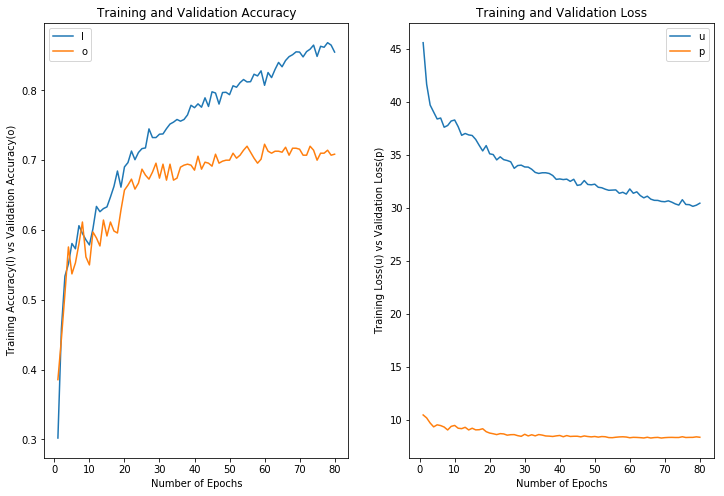

None


In [0]:
plt.figure(figsize: [12, 8])
plt.subplot(1, 2, 1)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Accuracy(l) vs Validation Accuracy(o)")
plt.plot(epochsRange, trainingAccuracy)
plt.plot(epochsRange, validationAccuracy)
var loc = "lower right"
plt.legend(loc)
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss(u) vs Validation Loss(p)")
plt.plot(epochsRange, trainingLoss)
plt.plot(epochsRange, validationLoss)
loc = "upper right"
plt.legend(loc)
plt.title("Training and Validation Loss")
plt.show()

# TODO: Experiment with Different Parameters

So far you've created a CNN with 3 convolutional layers and followed by a fully connected layer with 512 units. In the cells below create a new CNN with a different architecture. Feel free to experiement by changing as many parameters as you like. For example, you can add more convolutional layers, or more fully connected layers. You can also experiement with different filter sizes in your convolutional layers, different number of units in your fully connected layers, different dropout rates, etc... You can also experiment by performing image aumentation with more image transformations that we have seen so far. For example, you can add shear transformations, or you can vary the brightness of the images, etc... Experiment as much as you can and compare the accuracy of your various models. Which parameters give you the best result?